/tmp/ipython-input-3384464571.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


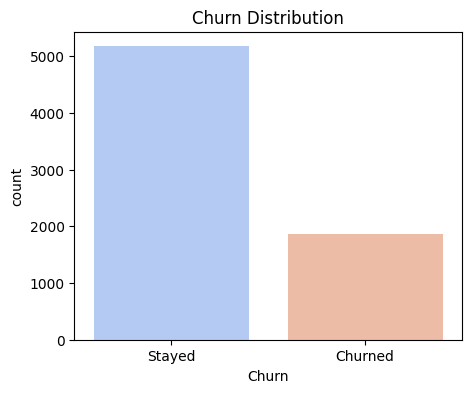

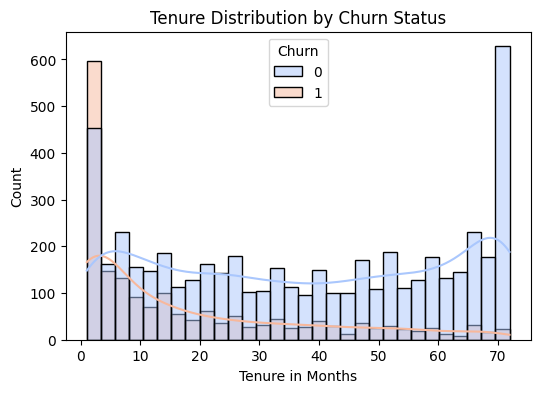

/tmp/ipython-input-3384464571.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Monthly Charge', data=df, palette='coolwarm')


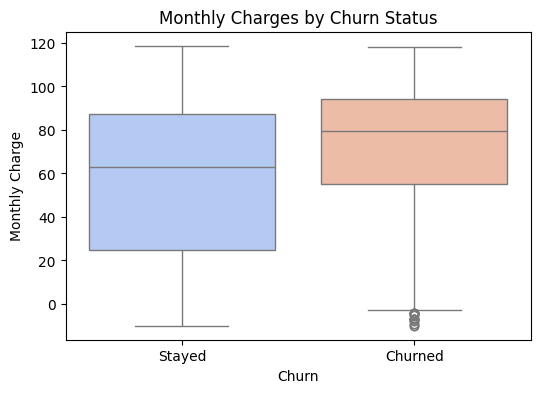

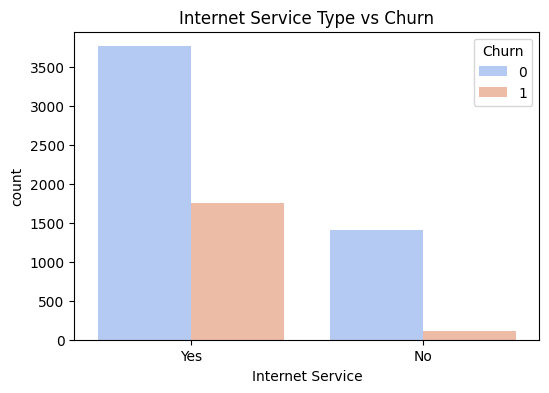

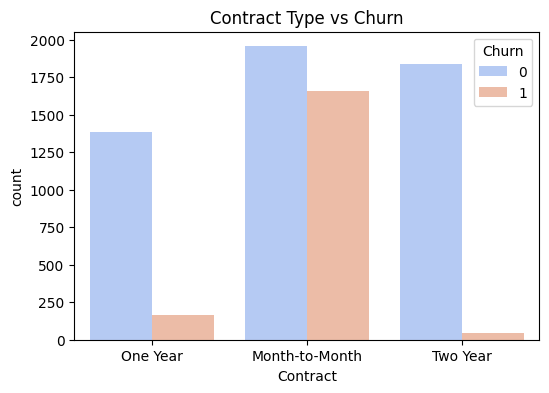

Model Performance
-----------------
Accuracy: 0.8311
ROC AUC Score: 0.8903

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1035
           1       0.72      0.59      0.65       374

    accuracy                           0.83      1409
   macro avg       0.79      0.76      0.77      1409
weighted avg       0.82      0.83      0.83      1409



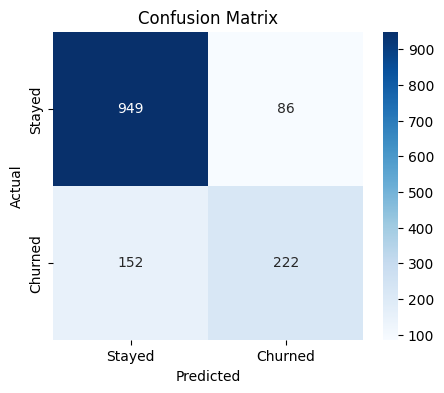

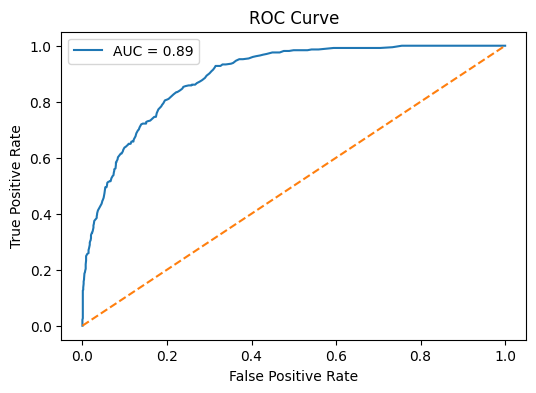

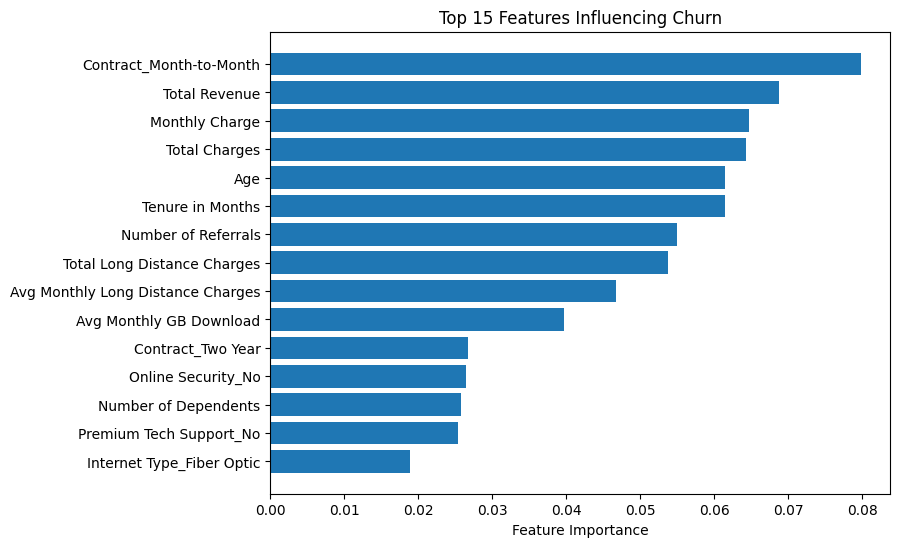

In [4]:
# ---------------------------------------------
# Customer Churn Prediction - SlashMark Project
# B.Tech (AI & Data Science)
# ---------------------------------------------

# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 2. Load Dataset
df = pd.read_excel('telecom_customer_churn.csv.xlsx')

# 3. Data Preprocessing
drop_cols = ['Customer ID', 'City', 'Zip Code', 'Latitude', 'Longitude',
             'Churn Category', 'Churn Reason']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

df['Churn'] = df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)
df.drop(columns=['Customer Status'], inplace=True)

# Convert object columns to numeric where possible
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass

# Identify categorical & numeric features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Churn']).columns.tolist()

# Fill missing values
df[categorical_features] = df[categorical_features].fillna('Unknown')
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

# 4. Exploratory Data Analysis (EDA)

# Churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title("Churn Distribution")
plt.xticks([0,1], ['Stayed', 'Churned'])
plt.show()

# Tenure vs Churn
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Tenure in Months', hue='Churn', bins=30, palette='coolwarm', kde=True)
plt.title("Tenure Distribution by Churn Status")
plt.show()

# Monthly Charges vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Monthly Charge', data=df, palette='coolwarm')
plt.title("Monthly Charges by Churn Status")
plt.xticks([0,1], ['Stayed', 'Churned'])
plt.show()

# Internet Service Type vs Churn
if 'Internet Service Type' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Internet Service Type', hue='Churn', data=df, palette='coolwarm')
    plt.title("Internet Service Type vs Churn")
    plt.show()

# Contract Type vs Churn
if 'Contract' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Contract', hue='Churn', data=df, palette='coolwarm')
    plt.title("Contract Type vs Churn")
    plt.show()

# 5. Train-Test Split
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Preprocessing & Model Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# 7. Model Training
model.fit(X_train, y_train)

# 8. Predictions & Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Performance")
print("-----------------")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed','Churned'], yticklabels=['Stayed','Churned'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance (from Random Forest)
feature_names = list(
    preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)
) + list(
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
)
importances = model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features Influencing Churn")
plt.show()

/tmp/ipython-input-1998978676.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette='coolwarm')


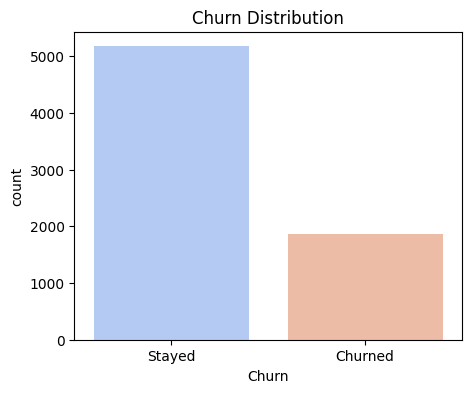

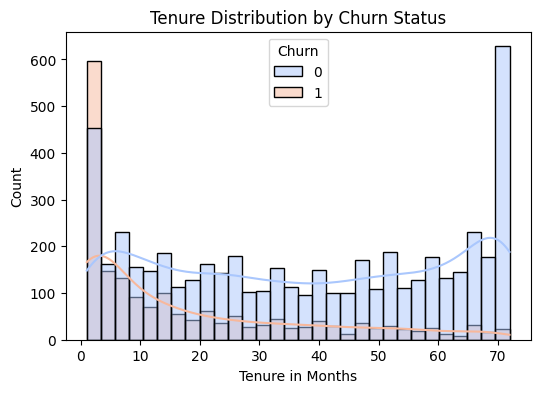

/tmp/ipython-input-1998978676.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='Monthly Charge', data=df, palette='coolwarm')


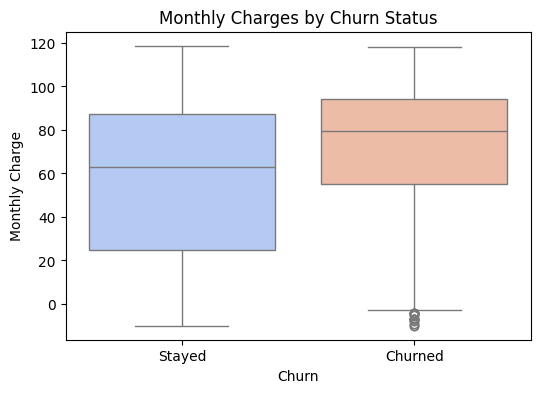

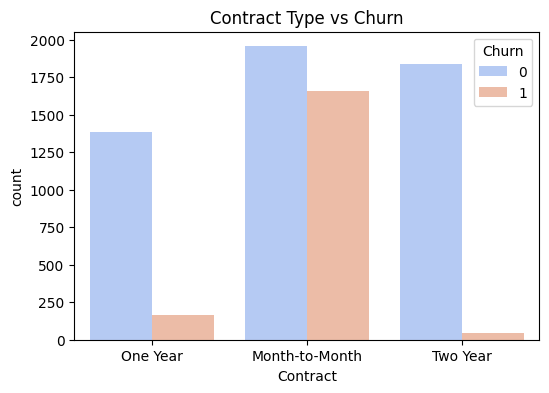

Model Performance
-----------------
Accuracy: 0.8311
ROC AUC Score: 0.8903

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1035
           1       0.72      0.59      0.65       374

    accuracy                           0.83      1409
   macro avg       0.79      0.76      0.77      1409
weighted avg       0.82      0.83      0.83      1409



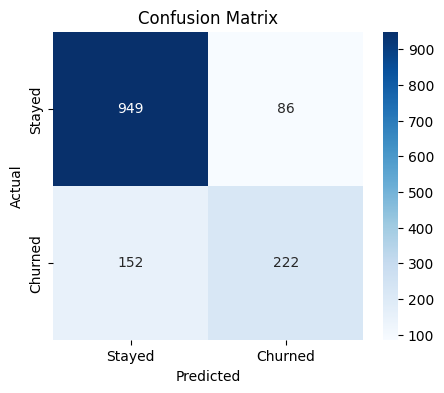

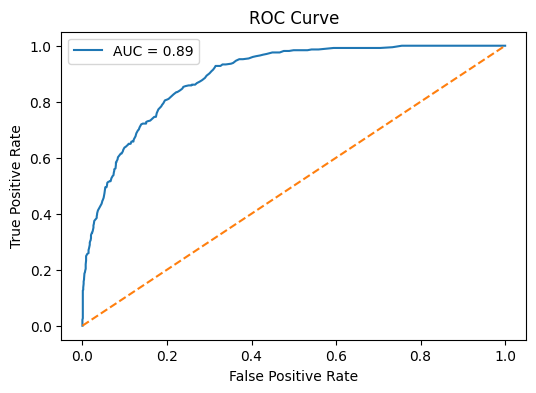

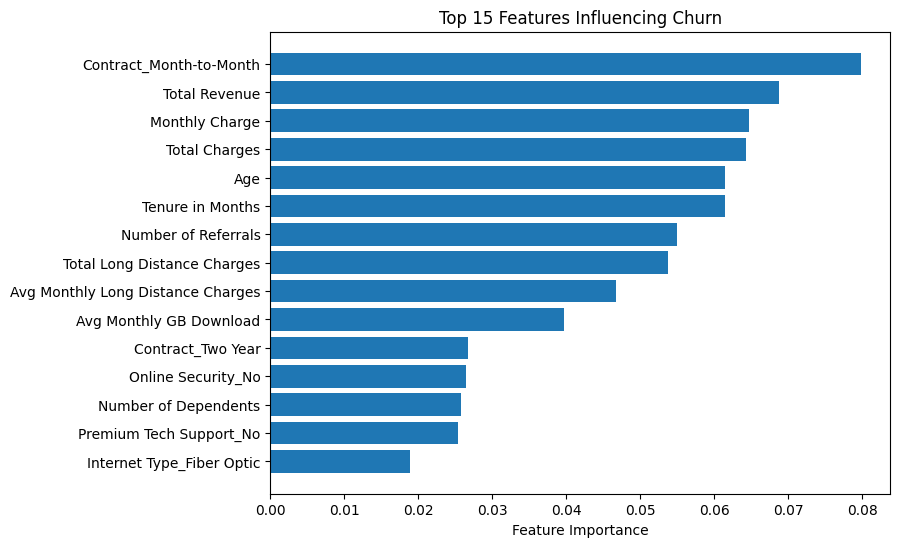

In [5]:
# ---------------------------------------------
# Customer Churn Prediction - SlashMark Project
# B.Tech (AI & Data Science)
# ---------------------------------------------

# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# 2. Load Dataset
df = pd.read_excel('telecom_customer_churn.csv.xlsx')

# 3. Data Preprocessing
drop_cols = ['Customer ID', 'City', 'Zip Code', 'Latitude', 'Longitude',
             'Churn Category', 'Churn Reason']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

df['Churn'] = df['Customer Status'].apply(lambda x: 1 if x == 'Churned' else 0)
df.drop(columns=['Customer Status'], inplace=True)

# Convert object columns to numeric where possible
for col in df.columns:
    if df[col].dtype == object:
        try:
            df[col] = pd.to_numeric(df[col])
        except:
            pass

# Identify categorical & numeric features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Churn']).columns.tolist()

# Fill missing values
df[categorical_features] = df[categorical_features].fillna('Unknown')
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].mean())

# 4. Exploratory Data Analysis (EDA)

# Churn distribution
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df, palette='coolwarm')
plt.title("Churn Distribution")
plt.xticks([0,1], ['Stayed', 'Churned'])
plt.show()

# Tenure vs Churn
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='Tenure in Months', hue='Churn', bins=30, palette='coolwarm', kde=True)
plt.title("Tenure Distribution by Churn Status")
plt.show()

# Monthly Charges vs Churn
plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='Monthly Charge', data=df, palette='coolwarm')
plt.title("Monthly Charges by Churn Status")
plt.xticks([0,1], ['Stayed', 'Churned'])
plt.show()

# Internet Service Type vs Churn
if 'Internet Service Type' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Internet Service Type', hue='Churn', data=df, palette='coolwarm')
    plt.title("Internet Service Type vs Churn")
    plt.show()

# Contract Type vs Churn
if 'Contract' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x='Contract', hue='Churn', data=df, palette='coolwarm')
    plt.title("Contract Type vs Churn")
    plt.show()

# 5. Train-Test Split
X = df.drop(columns=['Churn'])
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Preprocessing & Model Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# 7. Model Training
model.fit(X_train, y_train)

# 8. Predictions & Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Model Performance")
print("-----------------")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stayed','Churned'], yticklabels=['Stayed','Churned'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance (from Random Forest)
feature_names = list(
    preprocessor.named_transformers_['num'].get_feature_names_out(numeric_features)
) + list(
    preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
)
importances = model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 15 Features Influencing Churn")
plt.show()